
# WiDS Datathon 2025 — ADHD & Gender Classification

As part of the WiDS Datathon 2025 challenge, participants were tasked with a **multi-output classification** problem:  
to predict the presence of **ADHD (Attention Deficit Hyperactivity Disorder)** and the **gender** of a patient based on the provided data.

Two sources of features were used:
- **Tabular metadata** (quantitative and categorical),
- **FMRI connectome matrices** (functional MRI brain data).

I implemented an ensemble of two models:
- A separate model trained on tabular features (`XGBoost` + `MultiOutputClassifier`),
- A separate model trained on FMRI matrices,
- Their predictions were averaged to improve final accuracy.




In [ ]:
!pip install -q phik xgboost

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

## 📊 Exploratory Data Analysis (EDA)

In [8]:
cat_df_new = pd.read_excel('/content/drive/MyDrive/widsdatathon2025 (1)/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx')
num_df_new = pd.read_excel('/content/drive/MyDrive/widsdatathon2025 (1)/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx')
sol_df_new = pd.read_excel('/content/drive/MyDrive/widsdatathon2025 (1)/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx')

# Merging data
df = cat_df_new.merge(num_df_new, on="participant_id").merge(sol_df_new, on="participant_id")

# Basic info
print("Data shape:", df.shape)
print("\nMissing values by column:\n", df.isna().sum())


Размер данных: (1213, 30)

Пропуски по столбцам:
 participant_id                        0
Basic_Demos_Enroll_Year               0
Basic_Demos_Study_Site                0
PreInt_Demos_Fam_Child_Ethnicity     43
PreInt_Demos_Fam_Child_Race          54
MRI_Track_Scan_Location               3
Barratt_Barratt_P1_Edu               15
Barratt_Barratt_P1_Occ               31
Barratt_Barratt_P2_Edu              198
Barratt_Barratt_P2_Occ              222
EHQ_EHQ_Total                        13
ColorVision_CV_Score                 23
APQ_P_APQ_P_CP                       12
APQ_P_APQ_P_ID                       12
APQ_P_APQ_P_INV                      12
APQ_P_APQ_P_OPD                      12
APQ_P_APQ_P_PM                       12
APQ_P_APQ_P_PP                       12
SDQ_SDQ_Conduct_Problems              9
SDQ_SDQ_Difficulties_Total            9
SDQ_SDQ_Emotional_Problems            9
SDQ_SDQ_Externalizing                 9
SDQ_SDQ_Generating_Impact             9
SDQ_SDQ_Hyperactivity         

In [9]:
print("\nUnique values in categorical columns:")
for col in ['Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity',
            'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location']:
    print(f"{col}: {df[col].nunique()} unique values")


Уникальные значения в категориальных столбцах:
Basic_Demos_Study_Site: 4 уникальных значений
PreInt_Demos_Fam_Child_Ethnicity: 4 уникальных значений
PreInt_Demos_Fam_Child_Race: 10 уникальных значений
MRI_Track_Scan_Location: 4 уникальных значений


In [7]:
print("\nTarget class distribution:")
print("Sex_F:\n", df["Sex_F"].value_counts(normalize=True))
print("ADHD_Outcome:\n", df["ADHD_Outcome"].value_counts(normalize=True))


Баланс классов в таргетах:
Sex_F:
 Sex_F
0    0.657049
1    0.342951
Name: proportion, dtype: float64
ADHD_Outcome:
 ADHD_Outcome
1    0.685078
0    0.314922
Name: proportion, dtype: float64


## 📌 Target Variables Distribution (Sex & ADHD)

In [ ]:

# Plotting distribution of target labels
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x='sex', data=df, ax=axs[0])
axs[0].set_title('Gender Distribution')
axs[0].set_xticklabels(['Female (0)', 'Male (1)'])

sns.countplot(x='adhd', data=df, ax=axs[1])
axs[1].set_title('ADHD Diagnosis Distribution')
axs[1].set_xticklabels(['No ADHD (0)', 'ADHD (1)'])

plt.tight_layout()
plt.show()


## 🧠 FMRI Connectome Matrix Visualization

In [ ]:

# Restore a symmetric FMRI connectome matrix from a vector
def restore_symmetric_matrix(vec, size):
    mat = np.zeros((size, size))
    triu_indices = np.triu_indices(size, k=1)
    mat[triu_indices] = vec
    mat += mat.T  # make symmetric
    return mat

# Try restoring and plotting the first sample
vec = fmri_df.iloc[0, 1:].values  # skip ID column
sym_matrix = restore_symmetric_matrix(vec, size=200)

plt.figure(figsize=(6, 5))
sns.heatmap(sym_matrix, cmap='viridis')
plt.title("Sample Restored FMRI Connectome Matrix")
plt.xlabel("Region")
plt.ylabel("Region")
plt.show()


Процент пропусков:
 participant_id                       0.00
Basic_Demos_Enroll_Year              0.00
Basic_Demos_Study_Site               0.00
PreInt_Demos_Fam_Child_Ethnicity     3.54
PreInt_Demos_Fam_Child_Race          4.45
MRI_Track_Scan_Location              0.25
Barratt_Barratt_P1_Edu               1.24
Barratt_Barratt_P1_Occ               2.56
Barratt_Barratt_P2_Edu              16.32
Barratt_Barratt_P2_Occ              18.30
EHQ_EHQ_Total                        1.07
ColorVision_CV_Score                 1.90
APQ_P_APQ_P_CP                       0.99
APQ_P_APQ_P_ID                       0.99
APQ_P_APQ_P_INV                      0.99
APQ_P_APQ_P_OPD                      0.99
APQ_P_APQ_P_PM                       0.99
APQ_P_APQ_P_PP                       0.99
SDQ_SDQ_Conduct_Problems             0.74
SDQ_SDQ_Difficulties_Total           0.74
SDQ_SDQ_Emotional_Problems           0.74
SDQ_SDQ_Externalizing                0.74
SDQ_SDQ_Generating_Impact            0.74
SDQ_SDQ_Hypera

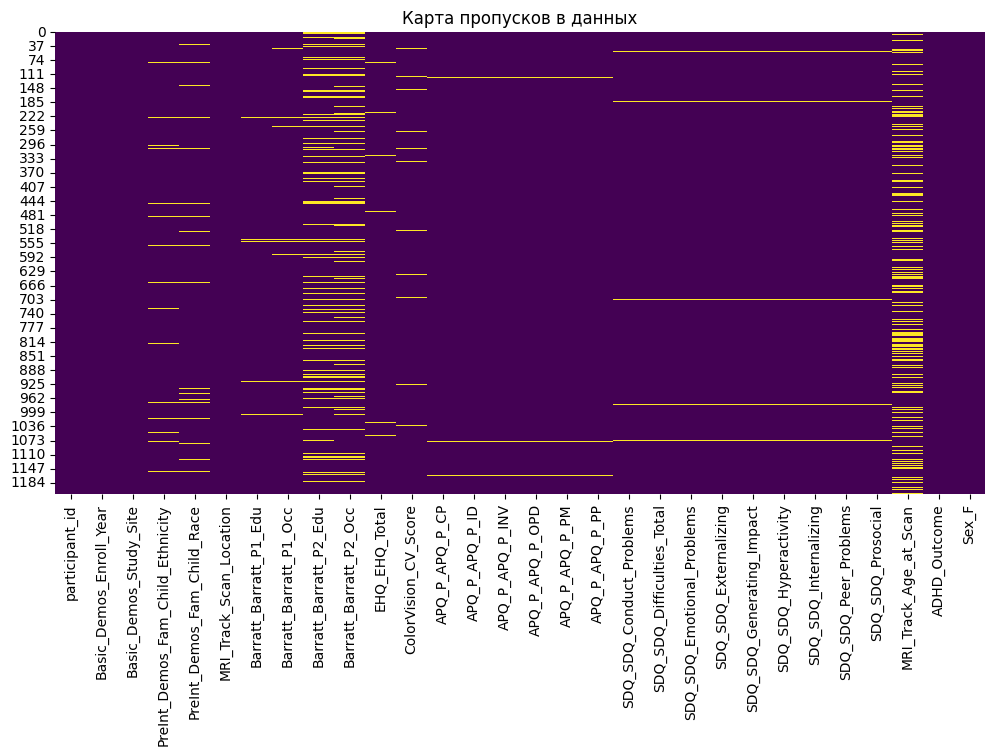


Пропуски в PreInt_Demos_Fam_Child_Ethnicity по ADHD_Outcome:
 ADHD_Outcome
0    0.065445
1    0.021661
Name: PreInt_Demos_Fam_Child_Ethnicity, dtype: float64
Пропуски в PreInt_Demos_Fam_Child_Ethnicity по Sex_F:
 Sex_F
0    0.032622
1    0.040865
Name: PreInt_Demos_Fam_Child_Ethnicity, dtype: float64

Пропуски в MRI_Track_Age_at_Scan по ADHD_Outcome:
 ADHD_Outcome
0    0.285340
1    0.302046
Name: MRI_Track_Age_at_Scan, dtype: float64
Пропуски в MRI_Track_Age_at_Scan по Sex_F:
 Sex_F
0    0.296110
1    0.298077
Name: MRI_Track_Age_at_Scan, dtype: float64


In [5]:
# Percentage of missing values
print("Missing value percentage:\n", (df.isnull().sum() / len(df) * 100).round(2))

# visualization пропусков
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Карта пропусков в данных")
plt.show()

# Correlation of missing values with ADHD_Outcome and Sex_F
for col in ['PreInt_Demos_Fam_Child_Ethnicity', 'MRI_Track_Age_at_Scan']:
    print(f"\nMissing in {col} by ADHD_Outcome:\n", df.groupby('ADHD_Outcome')[col].apply(lambda x: x.isnull().mean()))
    print(f"Missing in {col} by Sex_F:\n", df.groupby('Sex_F')[col].apply(lambda x: x.isnull().mean()))

## ⚙️ Data Preprocessing

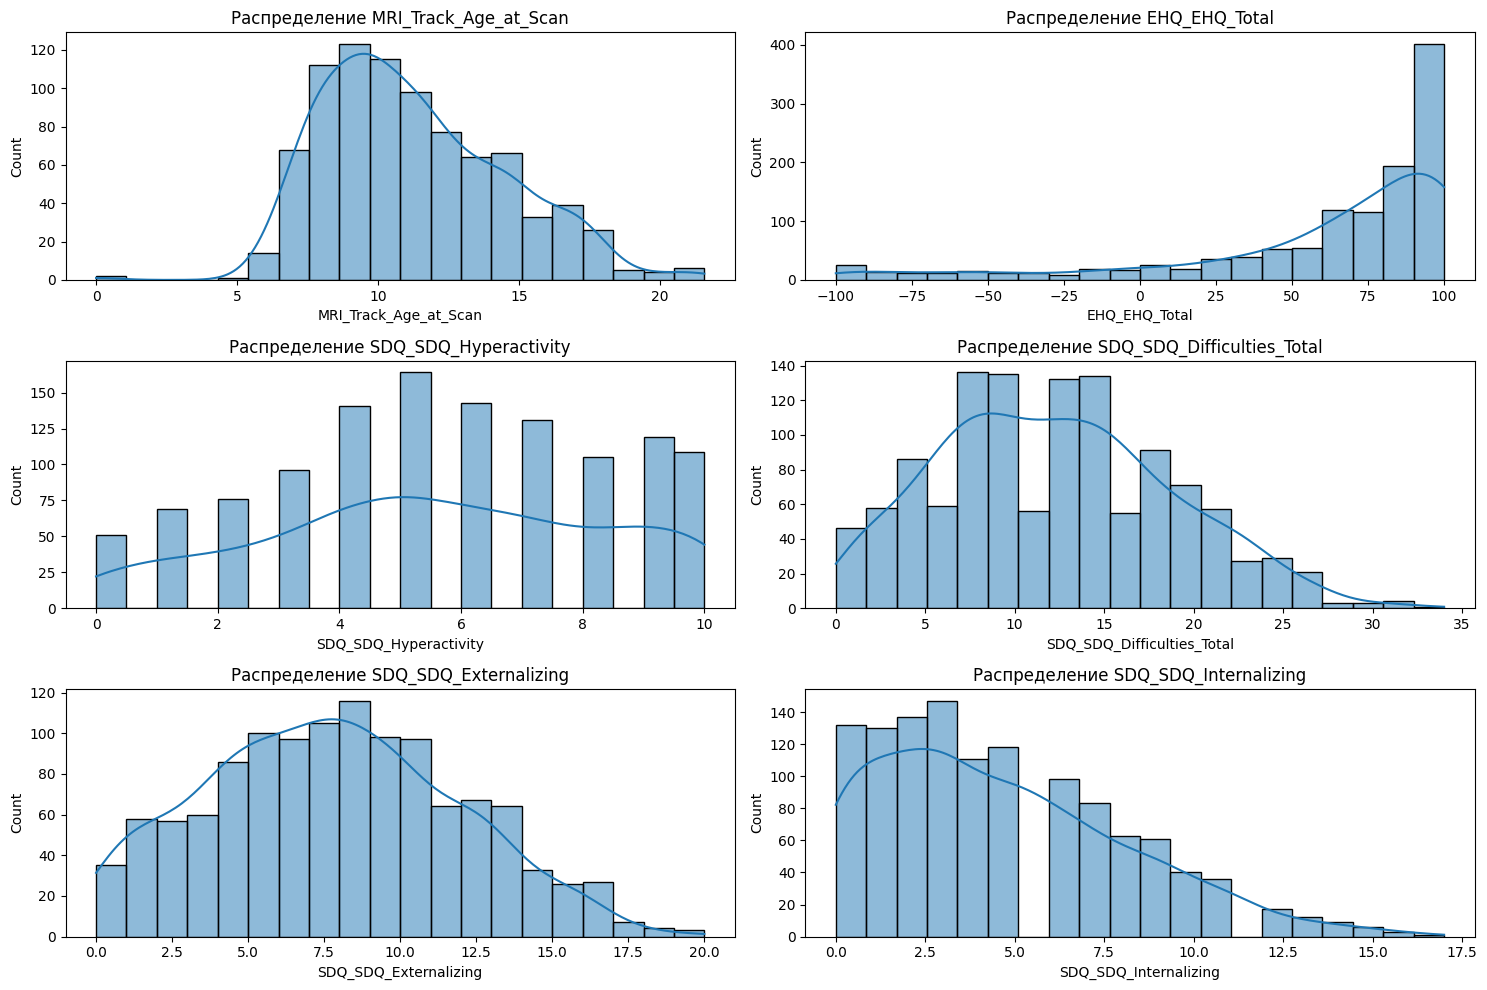

Статистики количественных признаков:
        MRI_Track_Age_at_Scan  EHQ_EHQ_Total  SDQ_SDQ_Hyperactivity  \
count             853.000000    1200.000000            1204.000000   
mean               11.245678      59.514750               5.539037   
std                 3.234372      49.744631               2.807063   
min                 0.000000    -100.000000               0.000000   
25%                 8.803901      46.670000               4.000000   
50%                10.739219      77.800000               6.000000   
75%                13.460871      94.470000               8.000000   
max                21.564453     100.000000              10.000000   

       SDQ_SDQ_Difficulties_Total  SDQ_SDQ_Externalizing  \
count                 1204.000000            1204.000000   
mean                    12.213455               7.613787   
std                      6.517330               4.130399   
min                      0.000000               0.000000   
25%                      7.0000

In [10]:
quant_cols = [
    'MRI_Track_Age_at_Scan', 'EHQ_EHQ_Total', 'SDQ_SDQ_Hyperactivity',
    'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Internalizing'
]

plt.figure(figsize=(15, 10))
for i, col in enumerate(quant_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], bins=20, kde=True)
    plt.title(f"Распределение {col}")
plt.tight_layout()
plt.show()

# Descriptive statistics
print("Quantitative feature statistics:\n", df[quant_cols].describe())

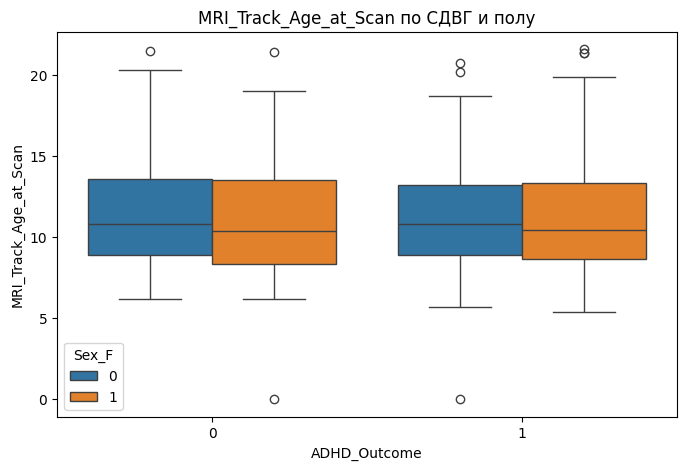

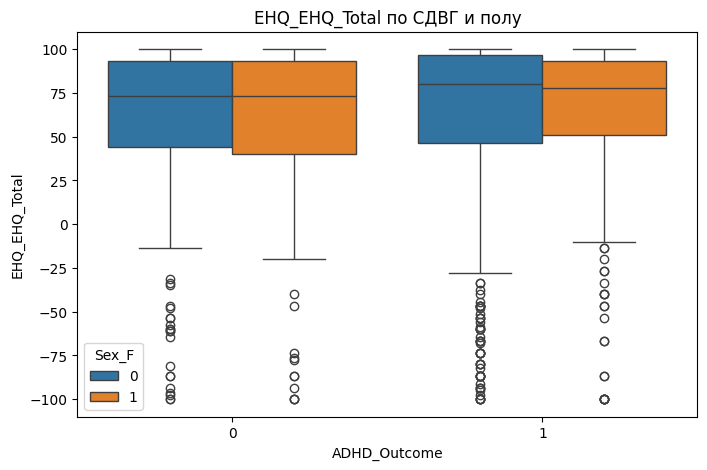

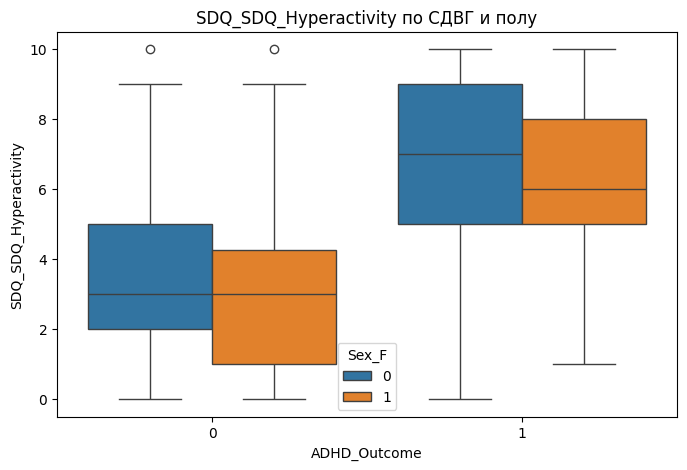

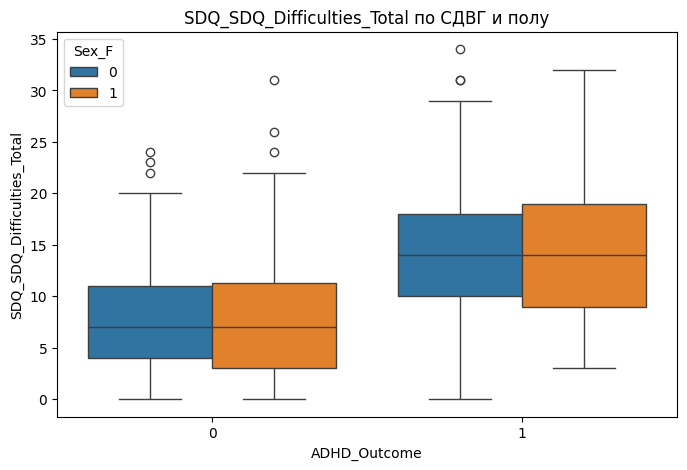

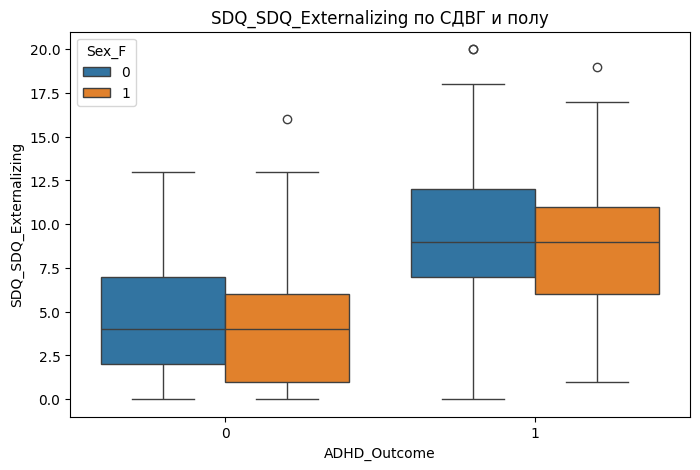

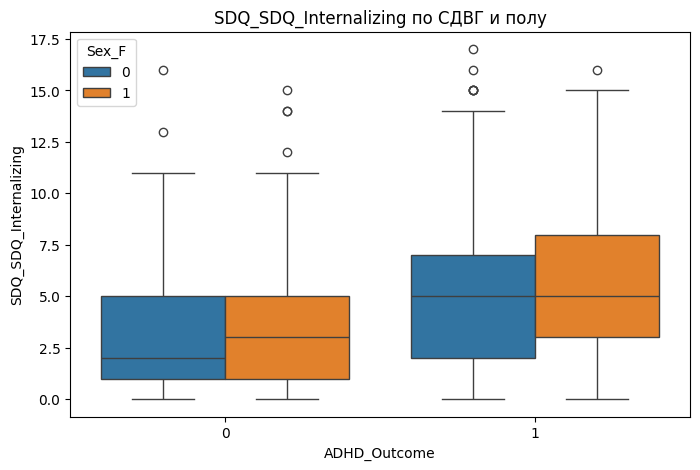

In [11]:
for col in quant_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='ADHD_Outcome', y=col, hue='Sex_F', data=df)
    plt.title(f"{col} по СДВГ и полу")
    plt.show()

In [12]:
!pip install phik -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/687.8 kB ? eta -:--:--
   ━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.6/687.8 kB 3.1 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 686.1/687.8 kB 9.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 7.8 MB/s eta 0:00:00


interval columns not set, guessing: ['Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu', 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu', 'Barratt_Barratt_P2_Occ', 'EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan', 'ADHD_Outcome', 'Sex_F']


/usr/local/lib/python3.11/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable participant_id is large: 1213. Are you sure this is not an interval variable? Analysis for pairs of variables including participant_id can be slow.
  warnings.warn(


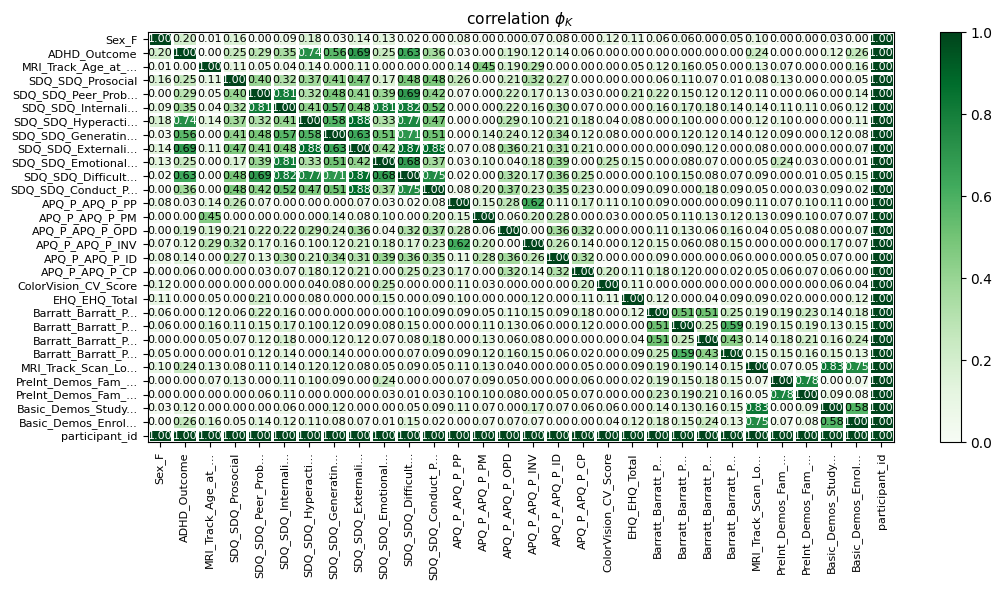

In [13]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

phik_overview = df.phik_matrix().round(2)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=0.8, figsize=(11, 6))
plt.tight_layout()

In [15]:
from sklearn.preprocessing import StandardScaler

def prepare_tabular_data(cat_path, num_path, target_path):
    # Loading data
    cat_df = pd.read_excel(cat_path)
    num_df = pd.read_excel(num_path)
    sol_df = pd.read_excel(target_path)

    df = cat_df.merge(num_df, on="participant_id").merge(sol_df, on="participant_id")

    # Creating Missing_P2 feature for missing second parent
    df['Missing_P2'] = ((df['Barratt_Barratt_P2_Edu'].isna()) |
                        (df['Barratt_Barratt_P2_Occ'].isna())).astype(int)

    # Handling missing values in categorical features
    df['PreInt_Demos_Fam_Child_Ethnicity'] = df['PreInt_Demos_Fam_Child_Ethnicity'].fillna('Missing')
    df['PreInt_Demos_Fam_Child_Race'] = df['PreInt_Demos_Fam_Child_Race'].fillna('Missing')

    # Handling scan age
    df['MRI_Track_Age_at_Scan'] = df['MRI_Track_Age_at_Scan'].fillna(
        df.groupby('Basic_Demos_Study_Site')['MRI_Track_Age_at_Scan'].transform('median')
    )


    # One-hot encoding for categorical features
    df = pd.get_dummies(df, columns=[
        'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity',
        'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location'
    ], prefix=['site', 'ethnicity', 'race', 'location'])

    # Categorizing EHQ_EHQ_Total
    df['EHQ_Category'] = pd.cut(df['EHQ_EHQ_Total'],
                                bins=[-float('inf'), -50, 0, 50, float('inf')],
                                labels=['Left', 'Mild Left', 'Mild Right', 'Right'])
    df = pd.get_dummies(df, columns=['EHQ_Category'], prefix='ehq')

    # Handling parental education
    df['Barratt_Barratt_P1_Edu'] = df['Barratt_Barratt_P1_Edu'].fillna(df['Barratt_Barratt_P1_Edu'].mode()[0])
    df['Barratt_Barratt_P2_Edu'] = df['Barratt_Barratt_P2_Edu'].fillna(df['Barratt_Barratt_P2_Edu'].mode()[0])
    edu_map = {3.0: 0, 6.0: 1, 9.0: 2, 12.0: 3, 15.0: 4, 18.0: 5, 21.0: 6}
    df['Barratt_Barratt_P1_Edu'] = df['Barratt_Barratt_P1_Edu'].map(edu_map)
    df['Barratt_Barratt_P2_Edu'] = df['Barratt_Barratt_P2_Edu'].map(edu_map)

    # One-hot encoding for parental occupations
    df = pd.get_dummies(df, columns=['Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ'],
                        prefix=['P1_Occ', 'P2_Occ'])

    # Converting bool to int
    for col in df.select_dtypes(include='bool').columns:
        df[col] = df[col].astype(int)

    # List of numeric columns for scaling
    quant = ['EHQ_EHQ_Total', 'ColorVision_CV_Score',
             'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
             'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP',
             'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total',
             'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing',
             'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity',
             'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems',
             'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan']

    # Imputing missing numeric values with median
    df[quant] = df[quant].fillna(df[quant].median())

    # Scaling
    scaler = StandardScaler()
    df[quant] = scaler.fit_transform(df[quant])

    # Splitting into X and y
    X = df.drop(columns=["participant_id", "Sex_F", "ADHD_Outcome"])
    y = df[["Sex_F", "ADHD_Outcome"]]

    return X, y

from imblearn.over_sampling import SMOTE

def balance_tabular_data_new(X, y):
    smote = SMOTE(random_state=42)

    if y.isna().sum().sum() > 0:
        raise ValueError("Пропуски в целевых переменных! Проверьте данные.")

    # First SMOTE: balancing ADHD_Outcome
    X_with_sex = X.copy()
    X_with_sex["Sex_F"] = y["Sex_F"]
    X_adhd_res, y_adhd_res = smote.fit_resample(X_with_sex, y["ADHD_Outcome"])
    sex_target = X_adhd_res["Sex_F"].reset_index(drop=True)
    X_adhd_res = X_adhd_res.drop(columns=["Sex_F"]).reset_index(drop=True)
    y_adhd_res = pd.Series(y_adhd_res).reset_index(drop=True)

    # Second SMOTE: balancing Sex_F
    X_balanced, y_sex_res = smote.fit_resample(X_adhd_res, sex_target)

    # Sync ADHD_Outcome with new data size
    # Repeat y_adhd_res to match new length
    n_repeats = len(y_sex_res) // len(y_adhd_res) + 1
    y_adhd_final = np.tile(y_adhd_res, n_repeats)[:len(y_sex_res)]

    # Final DataFrame
    y_final = pd.DataFrame({
        "Sex_F": y_sex_res,
        "ADHD_Outcome": y_adhd_final
    })

    # Removing NaNs (just in case)
    mask = y_final.dropna().index
    X_balanced = X_balanced.loc[mask].reset_index(drop=True)
    y_final = y_final.loc[mask].reset_index(drop=True)

    return X_balanced, y_final

## 🧠 Model Training

In [16]:
cat_path= '/content/drive/MyDrive/widsdatathon2025 (1)/TRAIN_NEW/TRAIN_CATEGORICAL_METADATA_new.xlsx'
num_path= '/content/drive/MyDrive/widsdatathon2025 (1)/TRAIN_NEW/TRAIN_QUANTITATIVE_METADATA_new.xlsx'
target_path= '/content/drive/MyDrive/widsdatathon2025 (1)/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx'
X, y = prepare_tabular_data(cat_path, num_path, target_path)
X_balanced, y_final = balance_tabular_data_new(X, y)

# Verification
print("Shape of X_balanced:", X_balanced.shape)
print("Class balance after SMOTE:")
print("Sex_F:\n", y_final["Sex_F"].value_counts(normalize=True))
print("ADHD_Outcome:\n", y_final["ADHD_Outcome"].value_counts(normalize=True))

Размер X_balanced: (2306, 70)
Баланс классов после SMOTE:
Sex_F:
 Sex_F
0    0.5
1    0.5
Name: proportion, dtype: float64
ADHD_Outcome:
 ADHD_Outcome
1    0.549003
0    0.450997
Name: proportion, dtype: float64


In [18]:
# Training XGBoost model with hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def train_xgboost_multioutput_with_tuning(X, y):
    # Разделение данных
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Базовые model
    sex_model = XGBClassifier(random_state=42)
    adhd_model = XGBClassifier(random_state=42)

    # Hyperparameter search space
    param_dist = {
        'estimator__n_estimators': [100, 200, 300],
        'estimator__max_depth': [3, 5, 7],
        'estimator__learning_rate': [0.01, 0.05, 0.1],
        'estimator__subsample': [0.8, 0.9, 1.0],
        'estimator__colsample_bytree': [0.8, 0.9, 1.0]
    }

    # Tuning for Sex_F
    multi_model_sex = MultiOutputClassifier(sex_model)
    random_search_sex = RandomizedSearchCV(
        multi_model_sex, param_distributions=param_dist, n_iter=20, cv=5,
        scoring='f1_macro', random_state=42, n_jobs=-1
    )
    random_search_sex.fit(X_train, y_train["Sex_F"].values.reshape(-1, 1))
    best_sex_model = random_search_sex.best_estimator_.estimators_[0]
    print("Best params for Sex_F:", random_search_sex.best_params_)

    # Tuning for ADHD_Outcome
    multi_model_adhd = MultiOutputClassifier(adhd_model)
    random_search_adhd = RandomizedSearchCV(
        multi_model_adhd, param_distributions=param_dist, n_iter=20, cv=5,
        scoring='f1_macro', random_state=42, n_jobs=-1
    )
    random_search_adhd.fit(X_train, y_train["ADHD_Outcome"].values.reshape(-1, 1))
    best_adhd_model = random_search_adhd.best_estimator_.estimators_[0]
    print("Best params for ADHD_Outcome:", random_search_adhd.best_params_)

    # Final model
    model = MultiOutputClassifier(estimator=best_sex_model)
    model.estimators_ = [best_sex_model, best_adhd_model]
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_sex = y_pred[:, 0]
    y_pred_adhd = y_pred[:, 1]

    # Metrics
    print("=== SEX PREDICTION ===")
    print(classification_report(y_test["Sex_F"], y_pred_sex))
    print(confusion_matrix(y_test["Sex_F"], y_pred_sex))

    print("\n=== ADHD PREDICTION ===")
    print(classification_report(y_test["ADHD_Outcome"], y_pred_adhd))
    print(confusion_matrix(y_test["ADHD_Outcome"], y_pred_adhd))

    return model

In [19]:
# Training XGBoost model with hyperparameter tuning
model_tab_tuned = train_xgboost_multioutput_with_tuning(X_balanced, y_final)

Лучшие параметры для Sex_F: {'estimator__subsample': 0.8, 'estimator__n_estimators': 200, 'estimator__max_depth': 5, 'estimator__learning_rate': 0.1, 'estimator__colsample_bytree': 0.8}
Лучшие параметры для ADHD_Outcome: {'estimator__subsample': 0.9, 'estimator__n_estimators': 200, 'estimator__max_depth': 7, 'estimator__learning_rate': 0.1, 'estimator__colsample_bytree': 1.0}
=== SEX PREDICTION ===
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       231
           1       0.76      0.81      0.79       231

    accuracy                           0.78       462
   macro avg       0.78      0.78      0.78       462
weighted avg       0.78      0.78      0.78       462

[[172  59]
 [ 43 188]]

=== ADHD PREDICTION ===
              precision    recall  f1-score   support

           0       0.72      0.67      0.70       209
           1       0.75      0.79      0.77       253

    accuracy                           0.74       462
   ma

In [20]:
# Extracting model for ADHD_Outcome
adhd_model = model_tab_tuned.estimators_[1]
feature_importances = adhd_model.feature_importances_
feature_names = X_balanced.columns

# Creating feature importance DataFrame
importances_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

# Displaying top 10 features
print("Top-10 important features for ADHD_Outcome:")
print(importances_df.head(10))

# Verification важности Missing_P2
print("\nImportance of Missing_P2:")
print(importances_df[importances_df["Feature"] == "Missing_P2"])

Топ-10 важных признаков для ADHD_Outcome:
                       Feature  Importance
16       SDQ_SDQ_Hyperactivity    0.062596
14       SDQ_SDQ_Externalizing    0.039777
31                    race_0.0    0.030367
15   SDQ_SDQ_Generating_Impact    0.027693
56                 P1_Occ_30.0    0.026420
44                location_3.0    0.025669
46                    ehq_Left    0.024913
50                  P1_Occ_0.0    0.023980
12  SDQ_SDQ_Difficulties_Total    0.022272
32                    race_1.0    0.021872

Важность Missing_P2:
       Feature  Importance
21  Missing_P2    0.010353


## 📈 Model Evaluation

In [17]:
fmri_path = "/content/drive/MyDrive/widsdatathon2025 (1)/TRAIN_NEW/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson.csv"
fmri_df = pd.read_csv(fmri_path)

print("Shape of fmri_df:", fmri_df.shape)
print("First 5 rows:")
print(fmri_df.head())
print("Columns:", fmri_df.columns.tolist())

Размер fmri_df: (1213, 19901)
Первые 5 строк:
  participant_id  0throw_1thcolumn  0throw_2thcolumn  0throw_3thcolumn  \
0   70z8Q2xdTXM3          0.222930          0.527903          0.429966   
1   WHWymJu6zNZi          0.614765          0.577255          0.496127   
2   4PAQp1M6EyAo         -0.116833          0.458408          0.260703   
3   obEacy4Of68I          0.199688          0.752714          0.658283   
4   s7WzzDcmDOhF          0.227321          0.613268          0.621447   

   0throw_4thcolumn  0throw_5thcolumn  0throw_6thcolumn  0throw_7thcolumn  \
0          0.060457          0.566489          0.315342          0.508408   
1          0.496606          0.404686          0.439724          0.122590   
2          0.639031          0.769337          0.442528          0.637110   
3          0.575096          0.692867          0.645789          0.522750   
4          0.562673          0.736709          0.589813          0.266676   

   0throw_8thcolumn  0throw_9thcolumn  ...  19

In [21]:
target_path = "/content/drive/MyDrive/widsdatathon2025 (1)/TRAIN_NEW/TRAINING_SOLUTIONS.xlsx"  # Укажи актуальный путь
target_df = pd.read_excel(target_path)
df_merged = pd.merge(fmri_df, target_df, on="participant_id")

print("Shape of df_merged:", df_merged.shape)
print("Missing values:", df_merged.isna().sum().sum())

Размер df_merged: (1213, 19903)
Пропуски: 0


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def preprocess_fmri_data_and_balance(df_merged, n_components=200):
    # Splitting X and y
    X_fmri = df_merged.drop(columns=["participant_id", "ADHD_Outcome", "Sex_F"])
    y_fmri = df_merged[["Sex_F", "ADHD_Outcome"]]

    # Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_fmri)

    # First SMOTE – for ADHD
    smote = SMOTE(random_state=42)
    X_res_adhd, y_res_adhd = smote.fit_resample(X_scaled, y_fmri["ADHD_Outcome"])

    # Restoring sex labels
    sex_labels = np.tile(y_fmri["Sex_F"], int(np.ceil(len(X_res_adhd) / len(y_fmri))))[:len(X_res_adhd)]

    # Second SMOTE – for sex
    X_res_final, y_res_sex = smote.fit_resample(X_res_adhd, sex_labels)

    # Финальные таргеты
    y_adhd_final = np.tile(y_res_adhd, int(np.ceil(len(y_res_sex) / len(y_res_adhd))))[:len(y_res_sex)]
    y_final = pd.DataFrame({
        "Sex_F": y_res_sex,
        "ADHD_Outcome": y_adhd_final
    })

    # PCA
    pca = PCA(n_components=n_components, random_state=42)
    X_reduced = pca.fit_transform(X_res_final)

    # Сохранение scaler и pca
    joblib.dump(scaler, "fmri_scaler.pkl")
    joblib.dump(pca, "fmri_pca.pkl")

    return X_reduced, y_final, scaler, pca

# Применение
X_reduced, y_final, scaler, pca = preprocess_fmri_data_and_balance(df_merged, n_components=200)
print("Shape of X_reduced:", X_reduced.shape)
print("Class balance after SMOTE:")
print("Sex_F:\n", y_final["Sex_F"].value_counts(normalize=True))
print("ADHD_Outcome:\n", y_final["ADHD_Outcome"].value_counts(normalize=True))

In [ ]:
# Training XGBoost model with hyperparameter tuning
model_fmri_new_tuned = train_xgboost_multioutput_with_tuning(X_reduced, y_final)

In [ ]:
# Function to prepare test tabular data for prediction
def prepare_tabular_test_data_new(cat_path, num_path):
    # Loading data
    cat_df = pd.read_excel(cat_path)
    num_df = pd.read_excel(num_path)

    df = cat_df.merge(num_df, on="participant_id")
    # Creating Missing_P2 feature for missing second parent
    df['Missing_P2'] = ((df['Barratt_Barratt_P2_Edu'].isna()) |
                        (df['Barratt_Barratt_P2_Occ'].isna())).astype(int)

    # Handling missing values in categorical features
    df['PreInt_Demos_Fam_Child_Ethnicity'] = df['PreInt_Demos_Fam_Child_Ethnicity'].fillna('Missing')
    df['PreInt_Demos_Fam_Child_Race'] = df['PreInt_Demos_Fam_Child_Race'].fillna('Missing')

    # Handling scan age
    df['MRI_Track_Age_at_Scan'] = df['MRI_Track_Age_at_Scan'].fillna(
        df.groupby('Basic_Demos_Study_Site')['MRI_Track_Age_at_Scan'].transform('median')
    )


    # One-hot encoding for categorical features
    df = pd.get_dummies(df, columns=[
        'Basic_Demos_Study_Site', 'PreInt_Demos_Fam_Child_Ethnicity',
        'PreInt_Demos_Fam_Child_Race', 'MRI_Track_Scan_Location'
    ], prefix=['site', 'ethnicity', 'race', 'location'])

    # Categorizing EHQ_EHQ_Total
    df['EHQ_Category'] = pd.cut(df['EHQ_EHQ_Total'],
                                bins=[-float('inf'), -50, 0, 50, float('inf')],
                                labels=['Left', 'Mild Left', 'Mild Right', 'Right'])
    df = pd.get_dummies(df, columns=['EHQ_Category'], prefix='ehq')

    # Handling parental education
    df['Barratt_Barratt_P1_Edu'] = df['Barratt_Barratt_P1_Edu'].fillna(df['Barratt_Barratt_P1_Edu'].mode()[0])
    df['Barratt_Barratt_P2_Edu'] = df['Barratt_Barratt_P2_Edu'].fillna(df['Barratt_Barratt_P2_Edu'].mode()[0])
    edu_map = {3.0: 0, 6.0: 1, 9.0: 2, 12.0: 3, 15.0: 4, 18.0: 5, 21.0: 6}
    df['Barratt_Barratt_P1_Edu'] = df['Barratt_Barratt_P1_Edu'].map(edu_map)
    df['Barratt_Barratt_P2_Edu'] = df['Barratt_Barratt_P2_Edu'].map(edu_map)

    # One-hot encoding for parental occupations
    df = pd.get_dummies(df, columns=['Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ'],
                        prefix=['P1_Occ', 'P2_Occ'])

    # Converting bool to int
    for col in df.select_dtypes(include='bool').columns:
        df[col] = df[col].astype(int)

    # List of numeric columns for scaling
    quant = ['EHQ_EHQ_Total', 'ColorVision_CV_Score',
             'APQ_P_APQ_P_CP', 'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV',
             'APQ_P_APQ_P_OPD', 'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP',
             'SDQ_SDQ_Conduct_Problems', 'SDQ_SDQ_Difficulties_Total',
             'SDQ_SDQ_Emotional_Problems', 'SDQ_SDQ_Externalizing',
             'SDQ_SDQ_Generating_Impact', 'SDQ_SDQ_Hyperactivity',
             'SDQ_SDQ_Internalizing', 'SDQ_SDQ_Peer_Problems',
             'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan']

    # Imputing missing numeric values with median
    df[quant] = df[quant].fillna(df[quant].median())

    # Scaling
    scaler = StandardScaler()
    df[quant] = scaler.fit_transform(df[quant])
    # Сохраняем participant_id отдельно
    participant_ids = df["participant_id"]
    X_test = df.drop(columns=["participant_id"])

    return X_test, participant_ids

def prepare_fmri_test_data(fmri_path):
    fmri_df = pd.read_csv(fmri_path)
    # Предполагается, что в тестовом наборе нет таргетов
    participant_ids = fmri_df["participant_id"]
    X = fmri_df.drop(columns=["participant_id"])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=200, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    return X_pca, participant_ids


In [ ]:
# Function to prepare test tabular data for prediction
# Загрузка тестовых tabular data
test_cat_path_new='/content/drive/MyDrive/widsdatathon2025 (1)/TEST/TEST_CATEGORICAL.xlsx'
test_num_path_new= '/content/drive/MyDrive/widsdatathon2025 (1)/TEST/TEST_QUANTITATIVE_METADATA.xlsx'
X_test_tab_new, test_ids_tab_new = prepare_tabular_test_data_new(test_cat_path_new, test_num_path_new)

# Приводим тестовые данные к тем же столбцам, что и обучающие (X_tabular_bal)
X_test_tab_aligned_new = X_test_tab_new.reindex(columns=X_balanced.columns, fill_value=0)

# Загрузка тестовых fmri данных
X_test_fmri_new, test_ids_fmri_new = prepare_fmri_test_data('/content/drive/MyDrive/widsdatathon2025 (1)/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv')

In [ ]:
# 2. Предсказания вероятностей
probs_fmri_new = model_fmri_new_tuned.predict_proba(X_test_fmri_new)  # <-- тут меняем, если надо
probs_tabular_new = model_tab_tuned.predict_proba(X_test_tab_aligned_new )
# 3. Если хочешь ансамбль (пример с ADHD=70% таб, Sex=70% fmri)
adhd_proba_tab = probs_tabular_new[1][:, 1]  # ADHD вероятность
adhd_proba_fmri = probs_fmri_new[1][:, 1]

sex_proba_tab = probs_tabular_new[0][:, 1]   # Sex вероятность
sex_proba_fmri = probs_fmri_new[0][:, 1]

final_adhd_new = (0.6 * adhd_proba_tab + 0.4* adhd_proba_fmri) >= 0.5
final_sex_new = (0.6 * sex_proba_tab + 0.4 * sex_proba_fmri) >= 0.5

## 📨 Submission Preparation
Final predictions and submission formatting.

In [ ]:
# Constructing final submission DataFrame

submission = pd.DataFrame({"participant_id": test_ids_fmri_new})
submission["ADHD_final"] = final_adhd_new.astype(int)
submission["Sex_final"] = final_sex_new.astype(int)

submission.to_csv("/content/final_submission_newdata.csv", index=False)